In [1]:
from st_utils import *
from H2TL import *

# some stuff to make this notebook work better with Scanpy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---
### Read in Visium ST Anndata
This uses standard `scanpy` functions

In [2]:
a1 = sc.read("data/V1_Adult_Mouse_Brain_Coronal_Section_1_raw.h5ad"); a1

AnnData object with n_obs × n_vars = 4992 × 21751
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
a2 = sc.read("data/V1_Adult_Mouse_Brain_Coronal_Section_2_raw.h5ad"); a2

AnnData object with n_obs × n_vars = 4992 × 21371
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

---
### Map ST data to histology pixels and trim images
This uses functions from `st_utils.py`

In [4]:
a1 = map_pixels(a1, filter_label="in_tissue")

Creating pixel grid and mapping to nearest barcode coordinates
Saving barcode mapping to adata.uns['pixel_map_df'] and adding metadata
Filtering barcodes using labels in self.adata.obs['in_tissue']
New size: 2903 spots x 21751 genes
Done!


Cropping image to pixel dimensions and adding values to adata.uns['pixel_map_df']
Cropping Visium spot coordinates and saving to adata.obsm['spatial_trim']
Saving cropped and trimmed image to adata.uns['spatial']['V1_Adult_Mouse_Brain_Coronal_Section_1']['images']['hires_trim']
Plotting pita as RGB image
Done!


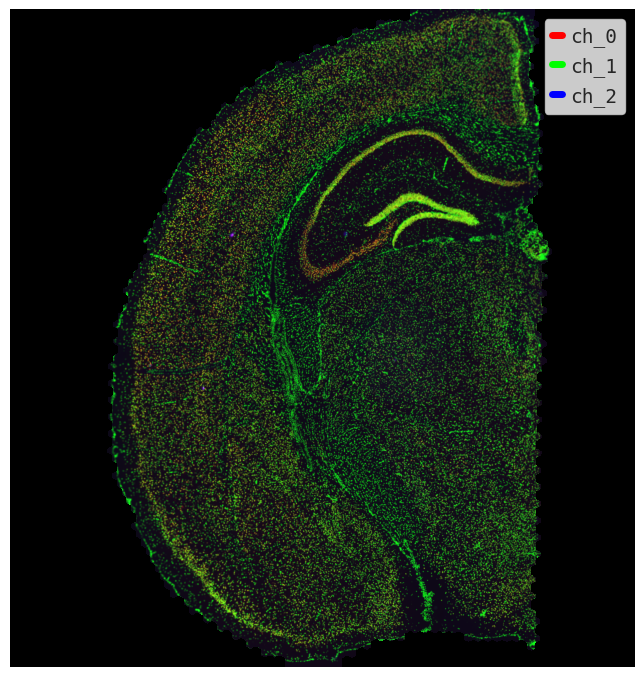

In [5]:
a1_image = trim_image(a1)

In [6]:
a2 = map_pixels(a2, filter_label="in_tissue")

Creating pixel grid and mapping to nearest barcode coordinates
Saving barcode mapping to adata.uns['pixel_map_df'] and adding metadata
Filtering barcodes using labels in self.adata.obs['in_tissue']
New size: 2807 spots x 21371 genes
Done!


Cropping image to pixel dimensions and adding values to adata.uns['pixel_map_df']
Cropping Visium spot coordinates and saving to adata.obsm['spatial_trim']
Saving cropped and trimmed image to adata.uns['spatial']['V1_Adult_Mouse_Brain_Coronal_Section_2']['images']['hires_trim']
Plotting pita as RGB image
Done!


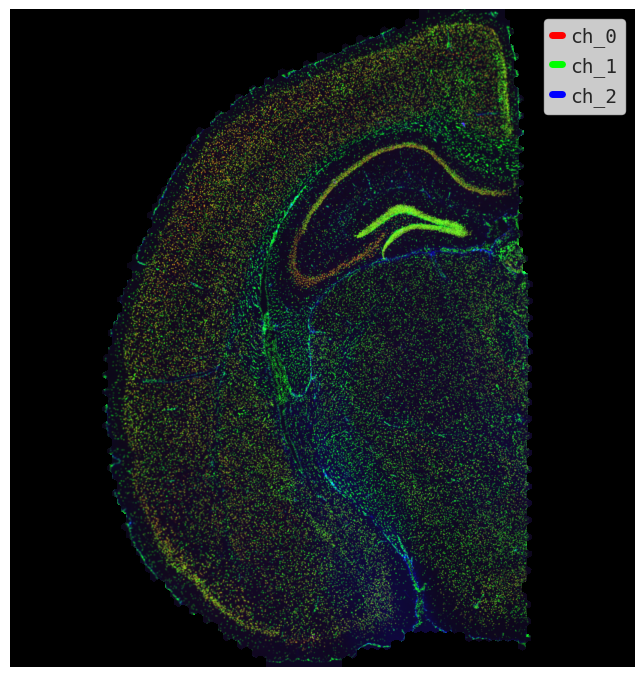

In [7]:
a2_image = trim_image(a2)

---
### Perform joint PCA to get a low-dimensional space for clustering
Again, standard `scanpy`/`anndata` functions here

In [8]:
a_comb = a1.concatenate([a2], fill_value=0, join="outer"); a_comb

AnnData object with n_obs × n_vars = 5710 × 22645
    obs: 'in_tissue', 'array_row', 'array_col', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1'
    obsm: 'spatial', 'spatial_trim', 'image_means'

In [9]:
sc.pp.normalize_total(a_comb)
sc.pp.log1p(a_comb)
sc.pp.scale(a_comb)
sc.pp.pca(a_comb, n_comps=50)

... storing 'in_tissue' as categorical
... storing 'gene_ids-0' as categorical
... storing 'gene_ids-1' as categorical


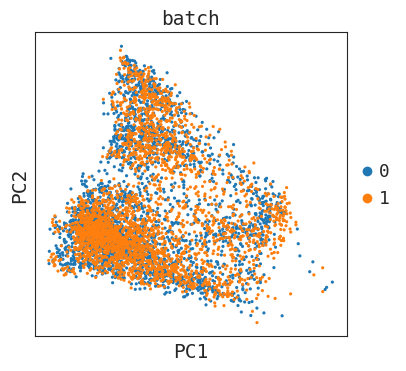

/Users/cody/.virtualenvs/sc/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/cody/.virtualenvs/sc/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


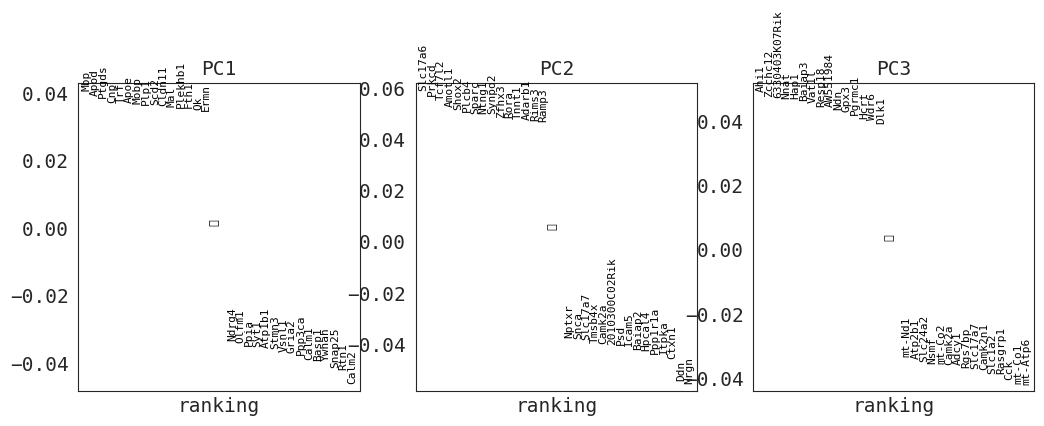

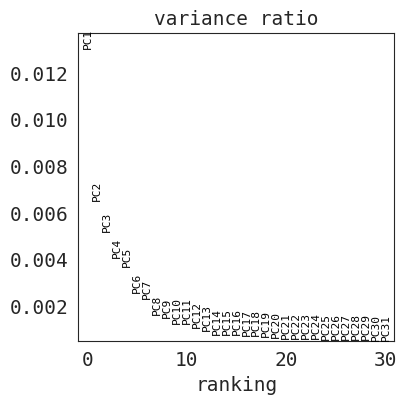

In [10]:
sc.pl.pca_overview(a_comb, color="batch")

In [11]:
# add PCA coordinates to original anndata objects
a1.obsm["X_pca"] = a_comb[a_comb.obs.batch=="0",:].obsm["X_pca"]
a2.obsm["X_pca"] = a_comb[a_comb.obs.batch=="1",:].obsm["X_pca"]

---
### Create `st_labeler` object and define macro clusters based on transcriptomics and histology
This comes from `H2TL.py`

In [12]:
tl = st_labeler([a1, a2])

Initiating ST labeler with 2 anndata objects


#### Since the first two channels of fluorescence in the two Visium sections are the same markers (third channel has extra antibody stain in section 2), we can use `fluor_channels=[0,1]` to add fluorescence measurements to the clustering model

In [13]:
%time tl.prep_cluster_data(use_rep="X_pca", features=[0,1,2,3,4,5,6,7,8,9], blur_pix=2, fluor_channels=[0,1])

Adding mean fluorescent channels [0, 1] for adata #0
Blurring training features for adata #0
Adding mean fluorescent channels [0, 1] for adata #1
Blurring training features for adata #1
Collected clustering data of shape: (5710, 12)
CPU times: user 1min 25s, sys: 228 ms, total: 1min 25s
Wall time: 1min 32s


#### We'll try labeling the tissue with 5 regional cluster IDs

Determining optimal cluster number k via scaled inertia


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  19 | elapsed:    5.1s remaining:   43.3s
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    5.2s remaining:   19.6s
[Parallel(n_jobs=-1)]: Done   6 out of  19 | elapsed:    5.4s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    5.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  10 out of  19 | elapsed:    5.8s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    5.9s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    6.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    6.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    6.5s finished


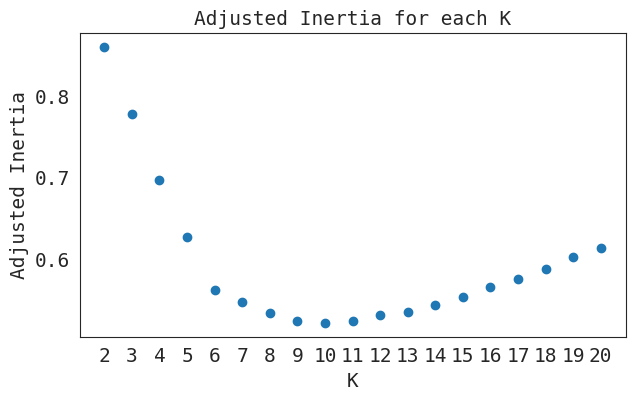

The optimal number of clusters is 10
Performing k-means clustering with 10 target clusters
Adding tissue_ID label to anndata objects
CPU times: user 1.29 s, sys: 257 ms, total: 1.54 s
Wall time: 7.96 s


In [14]:
%time tl.label_tissue_regions(plot_out=True)

#### Now show the features used for clustering after spatial blurring along with the final `tissue_ID` in each section

Assembling pita with 13 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!
Assembling pita with 13 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!


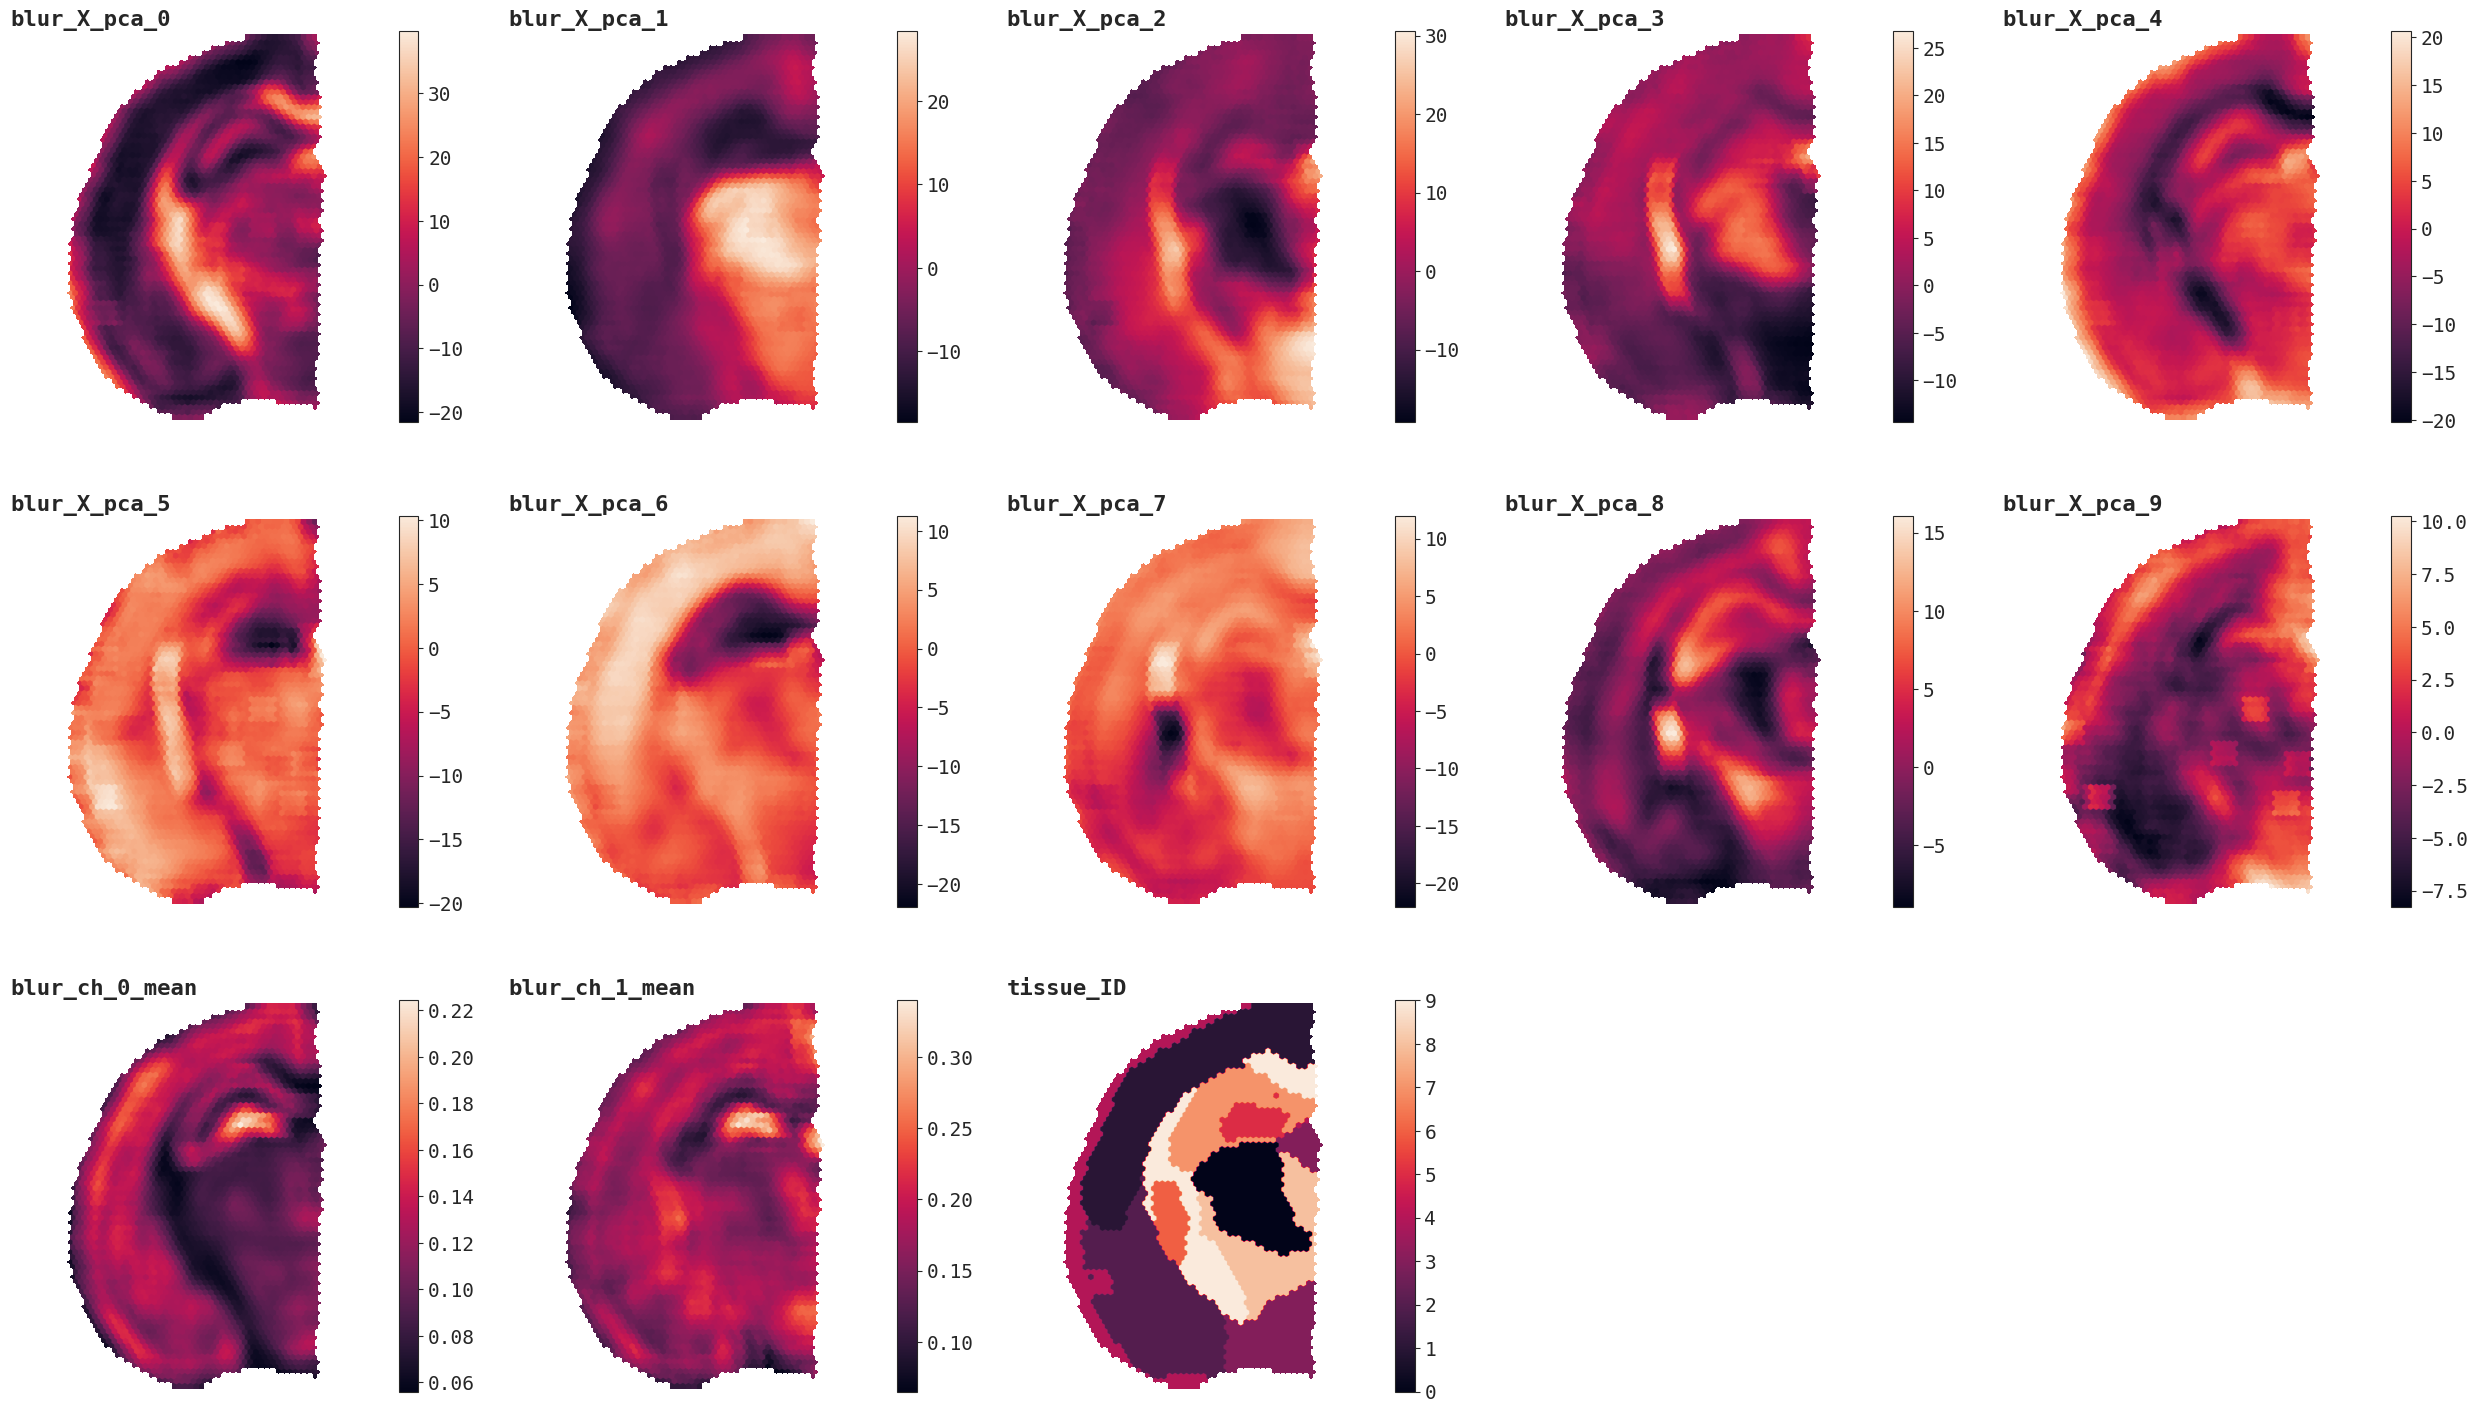

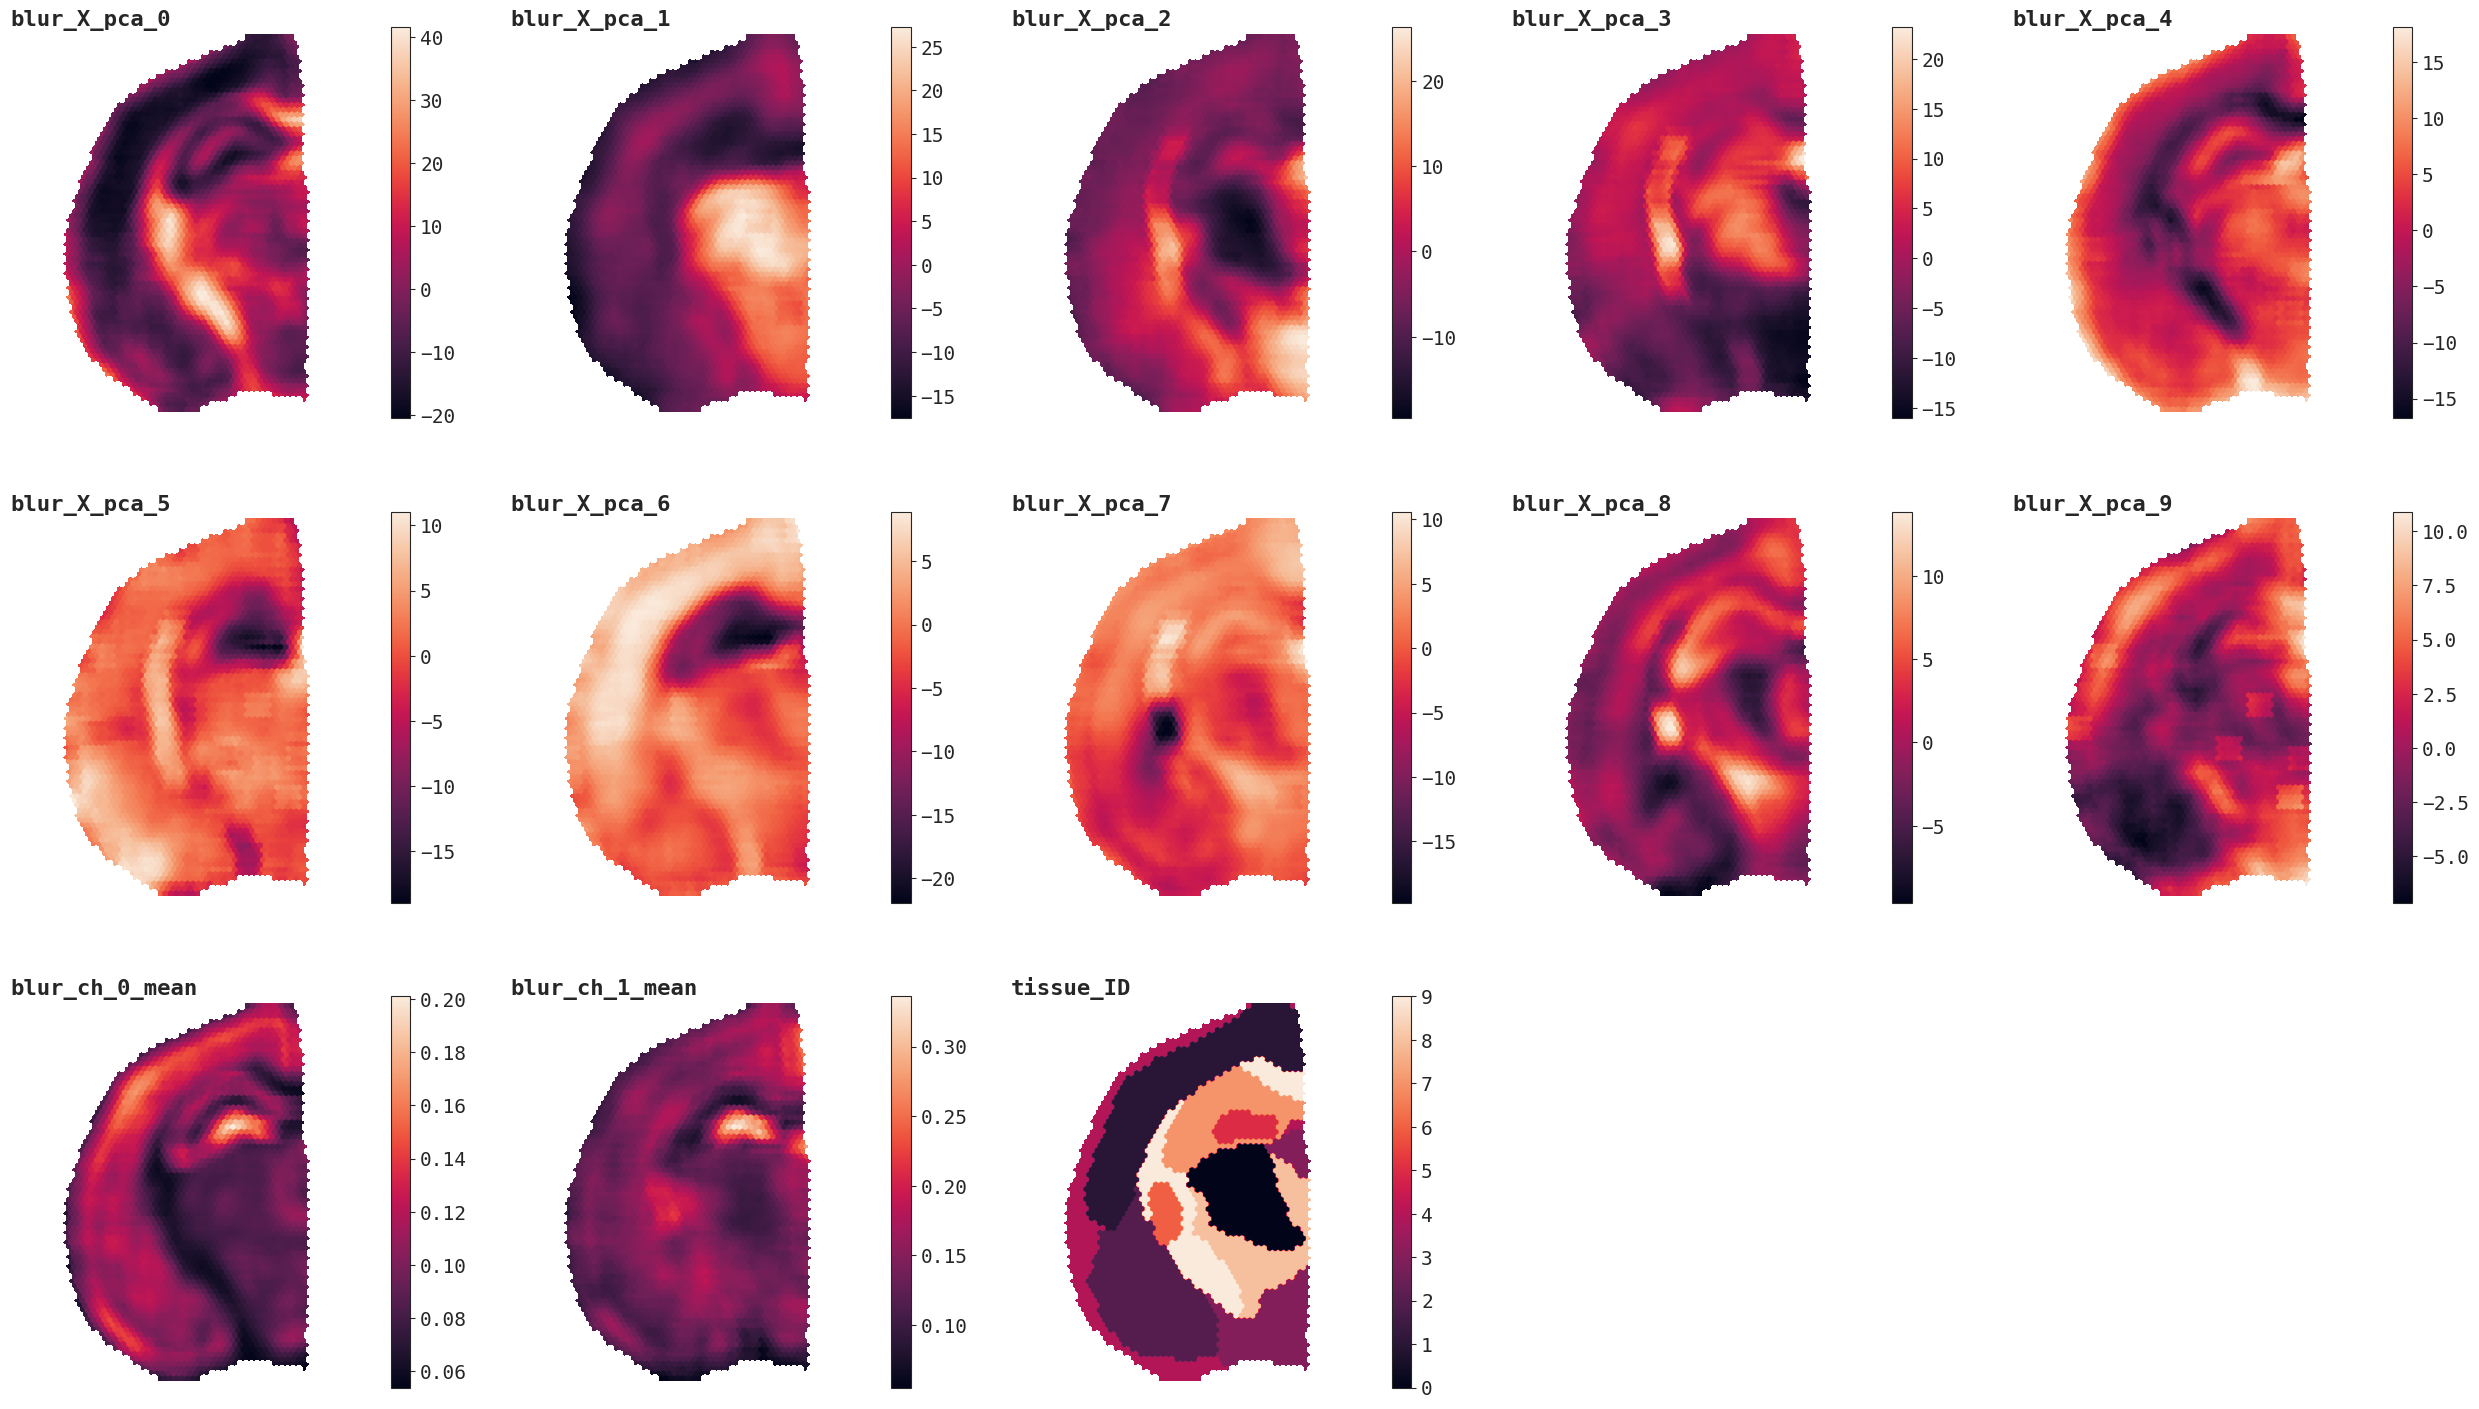

In [15]:
for i in range(len(tl.adatas)):
    n = list(tl.adatas[i].obs.columns[tl.adatas[i].obs.columns.str.startswith("blur_")]) + ["tissue_ID"]
    p = assemble_pita(tl.adatas[i], use_rep=".obs", features=n, ncols=5, label=n)

In [17]:
import matplotlib.pyplot as plt

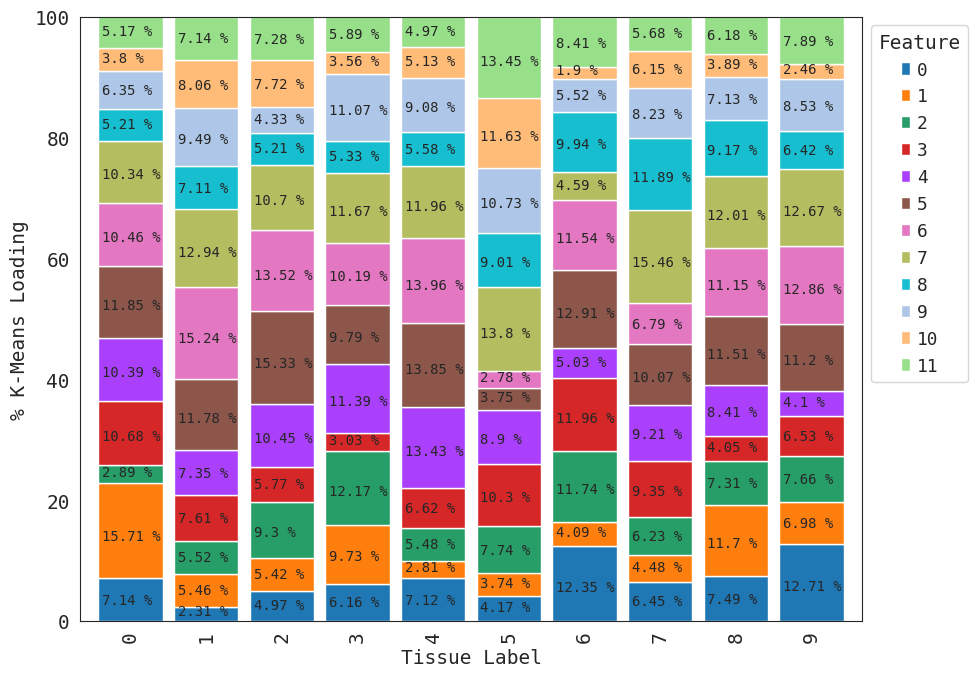

In [92]:
centers = pd.DataFrame(tl.kmeans.cluster_centers_)#, columns=["PC" + str(x) for x in tl.features])
totals = centers.sum(axis=1)
centers_prop = centers.div(totals, axis=0).multiply(100)

fig, ax = plt.subplots(1,1,figsize=(10,7))
centers_prop.plot.bar(stacked=True, ax=ax, width=0.85)
for p in ax.patches:
    ax.annotate('{} %'.format(str(np.round(p.get_height(), 2))), (p.get_x()+0.05, p.get_y()+(p.get_height()*0.4)), fontsize=10)
plt.ylim([0,100])
plt.xlabel("Tissue Label")
plt.ylabel("% K-Means Loading")
plt.legend(bbox_to_anchor=(1,1), loc="upper left", title="Feature")
plt.tight_layout()
plt.show()